KFolds with XGB to analyse best feats

In [1]:
import xgboost
from xgboost import XGBRegressor, XGBClassifier

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_log_error, r2_score, mean_squared_error

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from category_encoders import MEstimateEncoder, TargetEncoder
from sklearn.inspection import permutation_importance

import seaborn as sns
import shap

from tqdm import tqdm


from xgb_utils import cal_mean_errors
from xgb_params import xgb_params, xgb_params_inv, xgb_params_own

In [2]:
# CHANGE FILES/PARAMS TO USE
params = xgb_params_own
file_name = 'Own_Onehot_only_mean_NANs.csv'
feats_output_path = './best_feats/' + file_name

# For whole dataset
# data_set_path = '../../Dataset/train.csv/train.csv'

# For investment only dataset
# data_set_path = 'processed/train_inv.csv'

# For investment only dataset
data_set_path = 'processed/train_own.csv'

params

{'n_estimators': 250,
 'device': 'cuda',
 'objective': 'reg:squarederror',
 'eval_metric': 'rmsle',
 'enable_categorical': True,
 'early_stopping_rounds': 10,
 'colsample_bytree': 0.8,
 'eta': 0.05,
 'gamma': 8.084029345968737,
 'max_depth': 6,
 'min_child_weight': 2.0,
 'reg_alpha': 93.0,
 'reg_lambda': 0.8685796539747039,
 'n_jobs': 4}

In [5]:
# Import train data
train_df = pd.read_csv(data_set_path)

In [6]:

model1 =  XGBRegressor(
                    # verbosity=0,
                    n_estimators=params['n_estimators'],
                    device=params['device'],
                    objective=params['objective'],
                    eval_metric=params['eval_metric'],
                    enable_categorical=params['enable_categorical'],
                    early_stopping_rounds=params['early_stopping_rounds'],

                    eta=params['eta'],
                    max_depth = params['max_depth'],
                    # gamma = params['gamma'],
                    # reg_alpha = params['reg_alpha'],
                    # min_child_weight=params['min_child_weight'],
                    colsample_bytree=params['colsample_bytree'],
                    n_jobs=params['n_jobs']
                )

model2 = XGBRegressor(
                    # verbosity=0,
                    n_estimators=250,
                    device=params['device'],
                    objective=params['objective'],
                    eval_metric=params['eval_metric'],
                    enable_categorical=params['enable_categorical'],
                    early_stopping_rounds=params['early_stopping_rounds'],

                    eta=params['eta'],
                    max_depth = 6, #params['max_depth'],
                    # gamma = params['gamma'],
                    # reg_alpha = params['reg_alpha'],
                    # min_child_weight=params['min_child_weight'],
                    colsample_bytree=params['colsample_bytree'],
                    n_jobs=params['n_jobs']
                )

models = [model1] #, model2]

rmsles, most_important_features = cal_mean_errors(train_df, models)

0it [00:00, ?it/s]

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

**************************************************************************************************** 
 (8818, 403)


is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and w

**************************************************************************************************** 
 (8818, 403)


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

**************************************************************************************************** 
 (8818, 403)


is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecat

**************************************************************************************************** 
 (8819, 403)


is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecat

**************************************************************************************************** 
 (8819, 403)


is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecat

In [7]:
rmsles = np.array(rmsles)
print(rmsles)

[1393837.98691454]


In [8]:
for features in most_important_features:
    display(features.head(10))

,col_name,feature_importance_vals
0,full_sq,1.504508e+06
257,cafe_count_5000_price_2500,2.999382e+05
266,year,2.435916e+05
5,num_room,1.580913e+05
261,church_count_5000,1.535230e+05
211,cafe_count_2000_price_2500,1.461850e+05
203,cafe_count_2000,1.277830e+05
222,office_count_3000,1.084605e+05
2,floor,9.607931e+04
110,stadium_km,8.987322e+04


is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


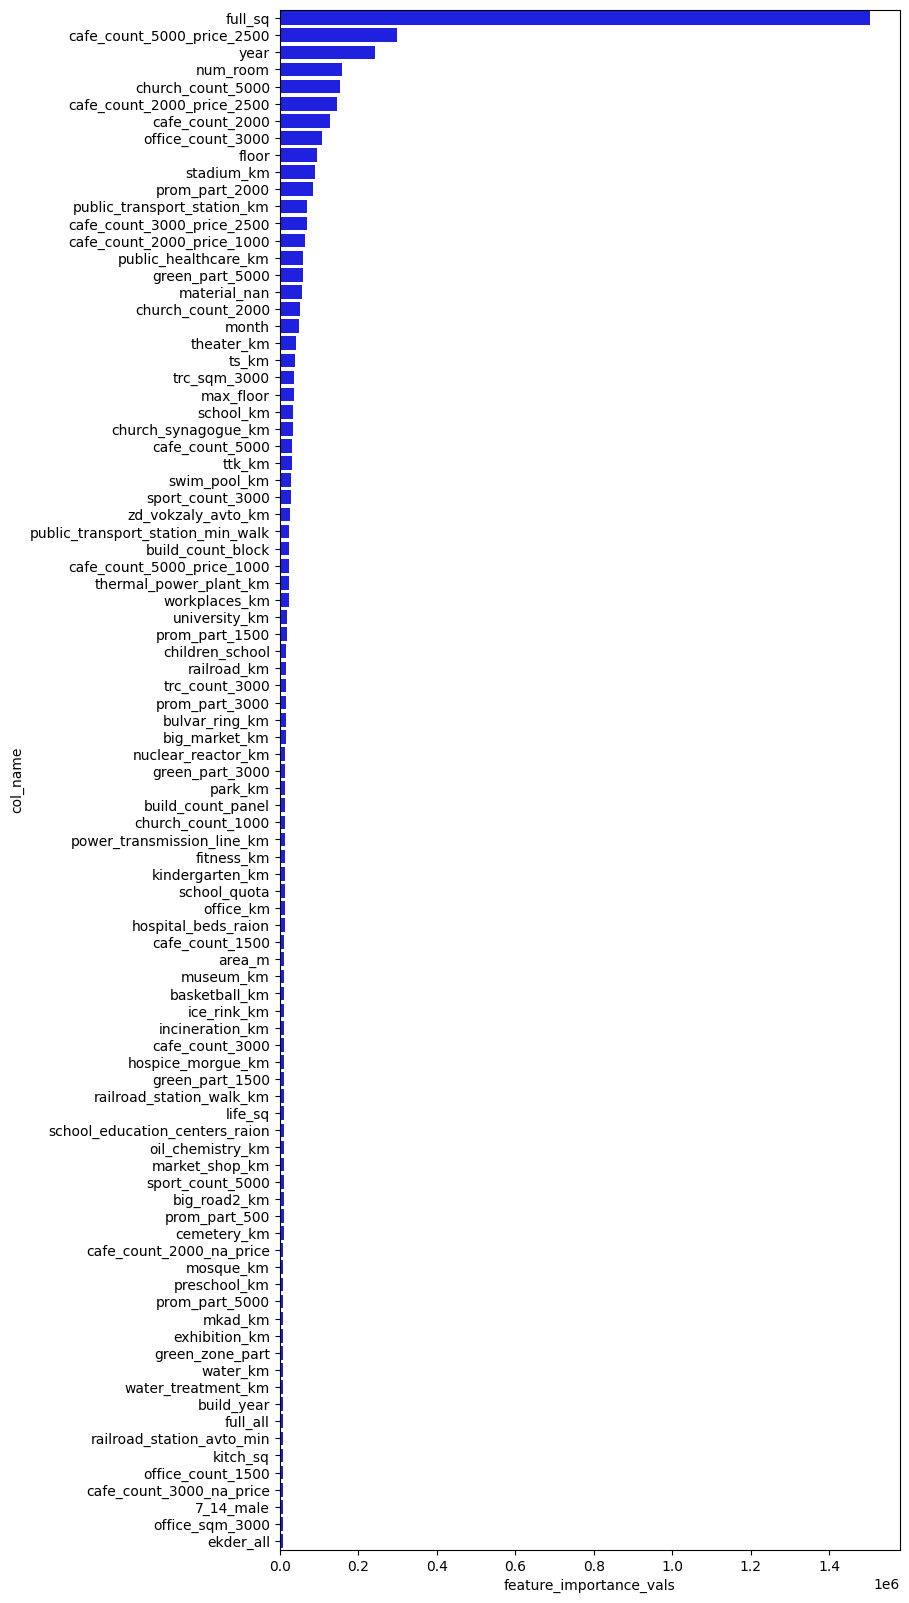

In [9]:
limit = 90
for feats in most_important_features:
    plt.figure(figsize=(8, 20))
    sns.barplot(x="feature_importance_vals", y="col_name", data=feats.iloc[:limit],
            color="b")

In [10]:
# Save best feats to csv
most_important_features[0].to_csv(feats_output_path, index=False)